# Classifying Songs on the Billboard Hot 100

- **True Positive**: Predict song is in the top 10, and it is in the top 10
- **False Positive**: Predict song is in the top 10, but it is not in the top 10
- **True Negative**: Predict song is not in the top 10, and it is not in the top 10
- **False Negative**: Predict song is not in the top 10, but it is in the top 10

- **High Recall**: Most top 10 songs were correctly predicted
    - No concern for number of songs that were incorrectly predicted as top 10
- **High Precision**: Among the predictions of top 10 songs, most predictions are correct
    - No concern for number of missed songs that were in top 10

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import pickle
import pandas_profiling
import patsy
from collections import defaultdict
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

# Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from yellowbrick.classifier import DiscriminationThreshold
from ipywidgets import interact

Using TensorFlow backend.
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.precision', 3)

## Target
- Top_10_Song

## Features
- Debut_Position
- Danceability
- Energy
- Loudness
- Acousticness
- Instrumentalness
- Liveness
- Valence
- Tempo
- Duration_min
- Performer_Count
- Song_Name_Count

### Dummy Features
- Debut_Month
- Debut_Season
- Debut_Decade
- Key
- Mode
- Time_Signature

### Load Dataset, Assign Features and Target

In [3]:
with open('song_features_modeling.pkl','rb') as read_file:
    songs_features_final_df = pickle.load(read_file)

In [4]:
songs_features_final_df[21668:21669]

,Top_10_Song,Song,Performer,SongID,Debut_Position,Debut_Week,Debut_Month,Debut_Season,Debut_Year,Debut_Decade,Peak_Position,Week_at_Peak,Peak_Month,Peak_Season,Peak_Year,Peak_Decade,Weeks_on_Chart,Weeks_in_Top10,Time_to_Top10,Danceability,Energy,Key,Loudness,Mode,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_min,Time_Signature,Performer_Count,Song_Name_Count,Debut_Season(T.Spring),Debut_Season(T.Summer),Debut_Season(T.Winter),Debut_Month(T.August),Debut_Month(T.December),Debut_Month(T.February),Debut_Month(T.January),Debut_Month(T.July),Debut_Month(T.June),Debut_Month(T.March),Debut_Month(T.May),Debut_Month(T.November),Debut_Month(T.October),Debut_Month(T.September),Debut_Decade(T.10's),Debut_Decade(T.50's),Debut_Decade(T.60's),Debut_Decade(T.70's),Debut_Decade(T.80's),Debut_Decade(T.90's),Key(T.B),Key(T.Bb),Key(T.C),Key(T.C#),Key(T.D),Key(T.D#),Key(T.E),Key(T.F),Key(T.F#),Key(T.G),Key(T.G#),Mode(T.Minor),Time_Signature(T.4/4),Time_Signature(T.5/4)
21668,1,Homicide,Logic Featuring Eminem,HomicideLogic Featuring Eminem,5,2019-05-18,May,Spring,2019,10's,5,2019-05-18,May,Spring,2019,10's,5,5.0,0 days,0.722,0.764,Bb,-5.656,Minor,0.145,0.0,0.171,0.796,139.831,4.09,4/4,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [5]:
# Remove multicollinear features (only look at months)

X_logit_mon_columns = ['Debut_Position', 'Song_Name_Count', 'Performer_Count', 'Danceability',    \
       'Energy', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness',    \
       'Valence', 'Tempo', 'Duration_min', 'Debut_Month(T.August)',    \
       'Debut_Month(T.December)', 'Debut_Month(T.February)',    \
       'Debut_Month(T.January)', 'Debut_Month(T.July)', 'Debut_Month(T.June)',    \
       'Debut_Month(T.March)', 'Debut_Month(T.May)', 'Debut_Month(T.November)',    \
       'Debut_Month(T.October)', 'Debut_Month(T.September)',    \
       "Debut_Decade(T.10's)", "Debut_Decade(T.50's)", "Debut_Decade(T.60's)",    \
       "Debut_Decade(T.70's)", "Debut_Decade(T.80's)", "Debut_Decade(T.90's)",    \
       'Key(T.B)', 'Key(T.Bb)', 'Key(T.C)', 'Key(T.C#)', 'Key(T.D)',    \
       'Key(T.D#)', 'Key(T.E)', 'Key(T.F)', 'Key(T.F#)', 'Key(T.G)',    \
       'Key(T.G#)', 'Mode(T.Minor)', 'Time_Signature(T.4/4)',    \
       'Time_Signature(T.5/4)']

In [6]:
X_beta_columns = ['Debut Position', 'Song Name Frequency', 'Artist Frequency',    \
                     'Danceability', 'Energy', 'Loudness', 'Acousticness', 'Instrumentalness',    \
                     'Liveness', 'Valence', 'Tempo', 'Duration (minutes)', 'Debut in August',    \
                     'Debut in December', 'Debut in February', 'Debut in January',    \
                     'Debut in July', 'Debut in June', 'Debut in March', 'Debut in May',    \
                     'Debut in November', 'Debut in October', 'Debut in September', "2010's Song",    \
                     "1950's Song", "1960's Song", "1970's Song", "1980's Song",    \
                     "1990's Song", 'Key of B', 'Key of Bb', 'Key of C',    \
                     'Key of C#', 'Key of D', 'Key of D#', 'Key of E',    \
                     'Key of F', 'Key of F#', 'Key of G', 'Key of G#',    \
                     'Song in Minor', '4/4 Time Signature', '5/4 Time Signature']

In [7]:
X_cleaned_columns = ['Debut Position', 'Song Name Frequency', 'Performer Frequency',    \
                     'Danceability', 'Energy', 'Loudness', 'Acousticness', 'Instrumentalness',    \
                     'Liveness', 'Valence', 'Tempo', 'Duration (minutes)', 'August',    \
                     'December', 'February', 'January',    \
                     'July', 'June', 'March', 'May',    \
                     'November', 'October', 'September', "2010's",    \
                     "1950's", "1960's", "1970's", "1980's",    \
                     "1990's", 'B', 'Bb', 'C',    \
                     'C#', 'D', 'D#', 'E',    \
                     'F', 'F#', 'G', 'G#',    \
                     'Minor', '4/4', '5/4']

In [8]:
# Remove multicollinear features (only look at seasons)
X_logit_mon = songs_features_final_df.loc[:, X_logit_mon_columns]
X_logit_mon.columns = X_cleaned_columns
y = songs_features_final_df['Top_10_Song']


In [9]:
X_logit_mon[21600:21601]

,Debut Position,Song Name Frequency,Performer Frequency,Danceability,Energy,Loudness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration (minutes),August,December,February,January,July,June,March,May,November,October,September,2010's,1950's,1960's,1970's,1980's,1990's,B,Bb,C,C#,D,D#,E,F,F#,G,G#,Minor,4/4,5/4
21600,25,1,26,0.287,0.364,-8.295,0.418,1.800e-05,0.185,0.11,103.777,4.524,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
X_logit_mon[21600:21601].values

array([[ 2.50000e+01,  1.00000e+00,  2.60000e+01,  2.87000e-01,
         3.64000e-01, -8.29500e+00,  4.18000e-01,  1.80000e-05,
         1.85000e-01,  1.10000e-01,  1.03777e+02,  4.52445e+00,
         0.00000e+00,  0.00000e+00,  1.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  0.00000e+00]])

### Logistic Regression - Unstandardized Coefficients

In [11]:
# Remove multicollinear features (only look at months)
X_train, X_test, y_train, y_test = train_test_split(X_logit_mon, y, test_size=0.2, stratify=y, random_state=42)

X_smote_columns = list(X_train.columns)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
beta = 2

In [14]:
cv_log_precision = defaultdict(list)
cv_log_recall = defaultdict(list)
cv_log_f1_score = defaultdict(list)

In [15]:
model_log_dict = {'Logistic Regression': LogisticRegression(solver = 'liblinear')}

for name, model in model_log_dict.items():
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_tr_ind, y_tr_ind = X_train[train_ind], y_train[train_ind]
        X_smote_train, y_smote_train = SMOTE(random_state=42).fit_sample(X_tr_ind, y_tr_ind)
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        
        logit_pre = model.fit(X_smote_train, y_smote_train)
        y_true = y_test
        y_pred = model.predict(X_test)
        
#         precision = 100*precision_score(y_val, y_pred)
#         recall = 100*recall_score(y_val, y_pred)
#         f1 = 100*f1_score(y_val, y_pred)
        
#         cv_log_precision[name].append(precision)
#         cv_log_recall[name].append(recall)
#         cv_log_f1_score[name].append(f1)


In [16]:
beta=2
f_beta_score = make_scorer(fbeta_score, beta=2)

logit_params = [{'solver':['liblinear']}]

gs_logit = GridSearchCV(LogisticRegression(), logit_params, cv=5, scoring=f_beta_score)

logit = gs_logit.fit(X_smote_train, y_smote_train)

print(logit.best_params_)
y_true, y_pred = y_test, logit.predict(X_test)

print(classification_report(y_true, y_pred))
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

f_beta = (prec*rec)/((beta**2*prec+rec)/(beta**2+1))
print('f_beta =', 100*f_beta.round(3))
print('accuracy =', accuracy_score(y_true, y_pred))

{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.70      0.78      3521
           1       0.33      0.65      0.44       819

    accuracy                           0.69      4340
   macro avg       0.61      0.67      0.61      4340
weighted avg       0.79      0.69      0.72      4340

f_beta = 54.50000000000001
accuracy = 0.6880184331797236


In [17]:
logit2 = LogisticRegression(solver = 'liblinear')
logit2 = logit2.fit(X_smote_train, y_smote_train)

In [18]:
y_targets = np.array(['Not Top 10 Song', 'Top 10 Song'])

In [23]:
logit2.feature_names = X_cleaned_columns
logit2.target_names = y_targets

In [24]:
logit2.feature_names

['Debut Position',
 'Song Name Frequency',
 'Performer Frequency',
 'Danceability',
 'Energy',
 'Loudness',
 'Acousticness',
 'Instrumentalness',
 'Liveness',
 'Valence',
 'Tempo',
 'Duration (minutes)',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 "2010's",
 "1950's",
 "1960's",
 "1970's",
 "1980's",
 "1990's",
 'B',
 'Bb',
 'C',
 'C#',
 'D',
 'D#',
 'E',
 'F',
 'F#',
 'G',
 'G#',
 'Minor',
 '4/4',
 '5/4']

In [25]:
with open("logit_model.pkl", "wb") as to_write:
    pickle.dump(logit2, to_write)

In [20]:
# precision_log_dict = {}
# recall_log_dict = {}
# f1_log_dict = {}

# for model, p in cv_log_precision.items():
#     precision_log_dict[model] = sum(p)/len(p)
# for model, r in cv_log_recall.items():
#     recall_log_dict[model] = sum(r)/len(r)
# for model, f in cv_log_f1_score.items():
#     f1_log_dict[model] = sum(f)/len(f)
    
# precision_log_df = pd.DataFrame(precision_log_dict.values(), index = precision_log_dict.keys())
# precision_log_df.columns = ['Precision']
# recall_log_df = pd.DataFrame(recall_log_dict.values(), index = recall_log_dict.keys())
# recall_log_df.columns = ['Recall']
# f1_log_df = pd.DataFrame(f1_log_dict.values(), index = f1_log_dict.keys())
# f1_log_df.columns = ['F1 Score']
# metric_log_df = precision_log_df.join(recall_log_df)
# metric_log_df = metric_log_df.join(f1_log_df)
# metric_log_df.round(1)

In [21]:
from ipywidgets import interact
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (logit.predict_proba(X_test)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fbeta = (precision*recall)/((beta**2*precision+recall)/(beta**2+1))
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['Not Top 10', 'Top 10'],
           yticklabels=['Not Top 10', 'Top 10'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic Regression Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F-beta: {:6.4f}".format(precision, recall, fbeta)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

In [32]:
FP = -2279
FN = -88*8
TP = 731*8
TN = 1242
profit = FP+FN+TP+TN
profit

4107

In [38]:
beta_list = []
beta_list2 = []
beta_list3 = []

for array in logit2.coef_:
    for i in array:
        odds = math.exp(i)
        probs = odds/(1+odds)
        beta_list.append(i)
        beta_list3.append(probs)
        

In [31]:
beta_coeffs_dict = {'Feature Name': X_beta_columns, 'Coefficient Value': beta_list}
beta_coeffs_df = pd.DataFrame(beta_coeffs_dict)
beta_coeffs_df = beta_coeffs_df.sort_values(by='Coefficient Value', ascending=True).reset_index(drop=True)
beta_coeffs_df

,Feature Name,Coefficient Value
0,2010's Song,-1.331
1,Energy,-0.949
2,Liveness,-0.756
3,Debut in August,-0.356
4,Instrumentalness,-0.337
5,Debut in December,-0.308
6,Debut in October,-0.174
7,Key of Bb,-0.156
8,Debut in March,-0.120
9,Debut in July,-0.115


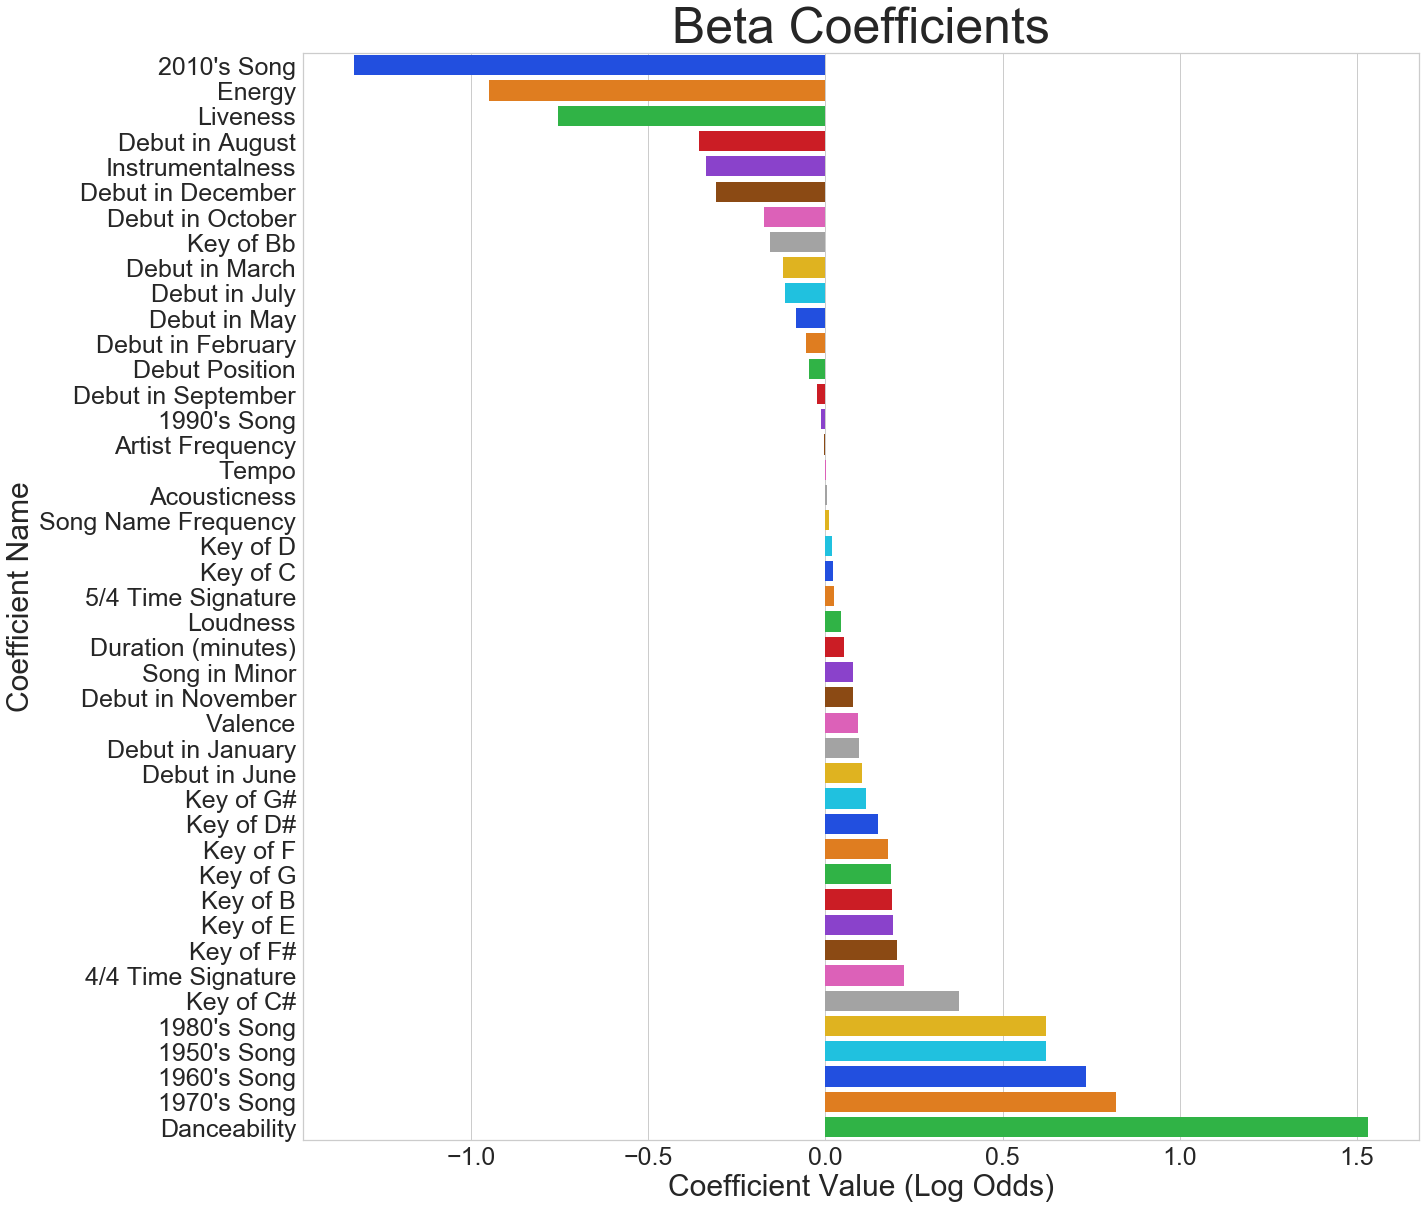

In [32]:
# Plot beta coefficients:

plt.figure(figsize=(20, 20))
plt.grid(axis='x', linestyle = '-')
sns.barplot(x = beta_coeffs_df['Coefficient Value'],y = beta_coeffs_df['Feature Name'], palette = "bright")
#             .set(xticklabels = ['-$10K', '-$5K', '$0', '$5K', '$10K', '$15K'], yticklabels = ['Concert in June', '# of Supporting Acts', 'Venue Capacity', 'Maximum Ticket Price', 'Minimum Ticket Price',  'Artist Genre: Indie Rock', 'Artist Genre: Electronic', 'Artist Genre: Pop', 'Artist Genre: Metal', 'Artist Genre: Jazz'])
plt.title('Beta Coefficients', fontsize = 50)
plt.xlabel('Coefficient Value (Log Odds)', fontsize = 30)
plt.ylabel('Coefficient Name', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
# for i in beta_coeffs:
#     bars.text(i.name,i.tip, round(i.total_bill,2), color='black', ha="center")
plt.show()

In [39]:
beta_coeffs_dict3 = {'Feature Name': X_beta_columns, 'Coefficient Value': beta_list3}
beta_coeffs_df3 = pd.DataFrame(beta_coeffs_dict3)
beta_coeffs_df3 = beta_coeffs_df3.sort_values(by='Coefficient Value', ascending=True).reset_index(drop=True)
beta_coeffs_df3

,Feature Name,Coefficient Value
0,2010's Song,0.209
1,Energy,0.279
2,Liveness,0.320
3,Debut in August,0.412
4,Instrumentalness,0.416
5,Debut in December,0.423
6,Debut in October,0.457
7,Key of Bb,0.461
8,Debut in March,0.470
9,Debut in July,0.471


In [40]:
beta_coefficients = beta_coeffs_df3.to_csv (r'/Users/andrewgraves/Data_Science/Metis/Bootcamp/project_3/beta_coefficients.csv', header=True)

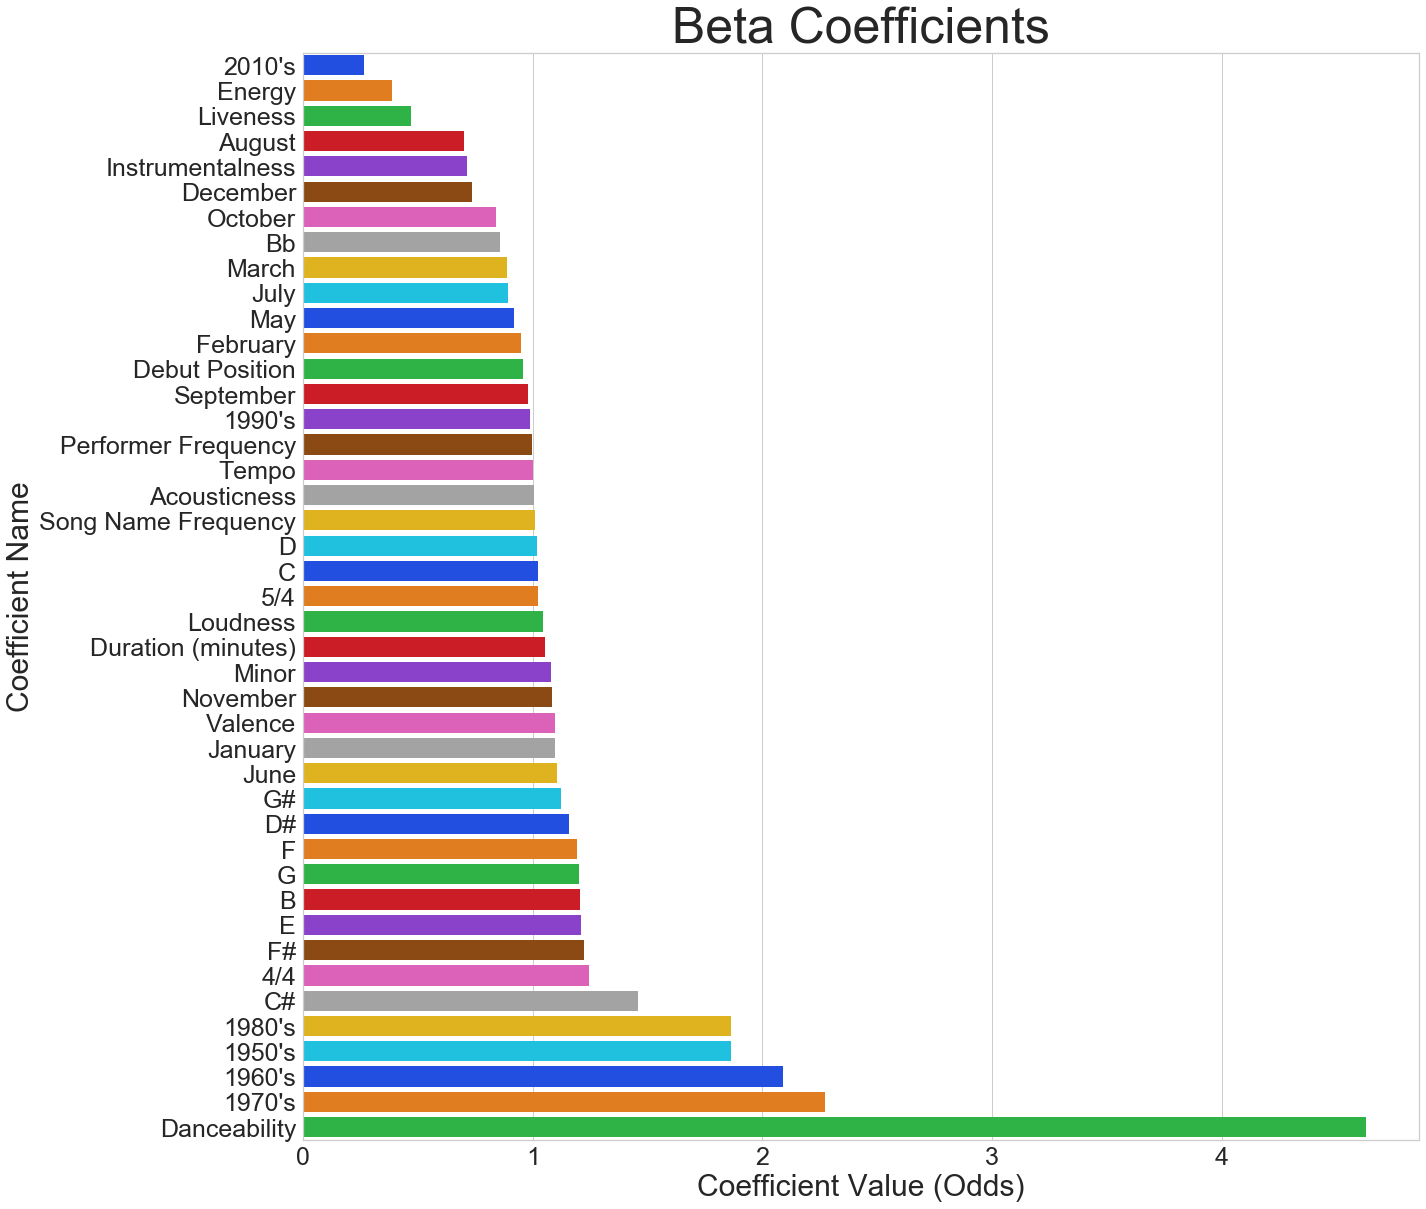

In [29]:
# Plot beta coefficients:

plt.figure(figsize=(20, 20))
plt.grid(axis='x', linestyle = '-')
sns.barplot(x = beta_coeffs_df2['Coefficient Value'],y = beta_coeffs_df2['Feature Name'], palette = "bright")
#             .set(xticklabels = ['-$10K', '-$5K', '$0', '$5K', '$10K', '$15K'], yticklabels = ['Concert in June', '# of Supporting Acts', 'Venue Capacity', 'Maximum Ticket Price', 'Minimum Ticket Price',  'Artist Genre: Indie Rock', 'Artist Genre: Electronic', 'Artist Genre: Pop', 'Artist Genre: Metal', 'Artist Genre: Jazz'])
plt.title('Beta Coefficients', fontsize = 50)
plt.xlabel('Coefficient Value (Odds)', fontsize = 30)
plt.ylabel('Coefficient Name', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
# for i in beta_coeffs:
#     bars.text(i.name,i.tip, round(i.total_bill,2), color='black', ha="center")
plt.show()

---